### Deep Mutational Screen of Illumina Amplicon Sequencing Data 

We start the analysis from (one or more) **Illumina** amplicon sequencing data sets, i.e. **fastq files** for the foward (R1) and respective reverse (R2) reads. 
Please run the `Illumina_preprocess_and_align_reads.py` file, which includes (1.) **demultiplexing** and **read quality filtering**, and (2.) **aligning** the reads to the reference using blastn. Please refer to the `README.md` file for details.

All the analysis below is also combined and automated in the `Illumina_analyze_mutation_enrichment.py` file. 

#### The notebook includes the following steps: 
Overall, we analyze the aligned reads, including calculation and visualization of: 
- insertions, deletions within the sequence (note that these may be sequencing errors or real biological effects)
- mutation enrichment within the sequence
- mutation rates
- mutagenic spectrum 
- Specific visualization of the results 


In [1]:
## import packages, the used versions are specified in the requirements.txt file
import os
import scipy
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import matplotlib.gridspec as gridspec
from preprocessing_functions import *
from plotting import *
from Illumina_functions import *
from importlib import reload
import json
from Bio import SeqIO
# Define the colors
from matplotlib.colors import LinearSegmentedColormap



custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    #"#2C3E5E",  
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
] , N=256)

custom_params = {"axes.spines.right": False, "axes.spines.top": False,'axes.linewidth':1}
sns.set_theme(context="paper",
              style='ticks',
              palette="Greys_r",rc=custom_params
             )
plt.rcParams['svg.fonttype'] = 'none'
lw = 1
lw = 1
fs = 7
hi = 10.5 *0.75 # 6.69291
wi3 = 2.24 # 7.08661
wi2 = 4.76
wi1 = 7.24
nr = 5

short_fn = np.vectorize(lambda x: x[:5])
#matplotlib.rcParams.update({'font.size': fs})
matplotlib.rcParams['axes.linewidth'] = 1
sns.set_context("paper", rc={"font.size":fs,
                             "axes.titlesize":fs+1,
                             "axes.labelsize":fs,
                             'axes.linewidth':1,    
                            "xtick.labelsize": fs,
                            "ytick.labelsize": fs,
                            "legend.fontsize": fs,
                            "legend.title_fontsize": fs+1}) 

### Read and restructure the blast alignment data

In [2]:
###### specify the parameters for the analysis ######


homedir =  "data/Illumina/P02_RL8_LOV2" ## folder where the fastq files are stored

Bc = "BC1" ## barcode that should be analyzed
read_dirs = ["R1", "R2"] ## which reads should be analyzed
Section = "S1" ## which section should be analyzed
all_alignments = {}
data_type = "AA" ## which data_type should be analyzed, either "AA" or "Nt"

LOV_startseq = "ttagccacaa".upper() ## region of interest
LOV_endseq = "cggccaaa".upper()

with open(f"{homedir}/config.json") as f:
  config = json.load(f)

variant = config["variant"]

FigFolder = f"{os.getcwd()}/final_output/{variant}_w_nb/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

  

In [3]:
###### read the blast alignments ######

all_alignments = {}
all_coverages = {}
data_type = "AA"

for read_dir in read_dirs:

    # Open the blast oujtplut JSON file and load it as a dictionary
    print("################",  read_dir,   "################")
    with open(f"{homedir}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
        blast_output = json.load(file)

    ## reference
    amplicon_seq = str(SeqIO.read(f"{homedir}/references/{variant}_{Bc}_{Section}_Nt_filt_ref.fasta", "fasta").seq)

    amplicon_AA = translate_dna2aa(amplicon_seq)

    blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()

    LOV2_startidx = amplicon_seq.index(LOV_startseq)
    LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)

    ### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
    print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

    filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

    blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
    print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")

    ## restructure the blast alignments to store only the (for us) relevant sequence information
    alignments, coverages = restructure_alignments(blast_alignments, query_seq=amplicon_seq, read_dir=read_dir)

    all_alignments[read_dir] = alignments
    all_coverages[read_dir] = coverages



################ R1 ################
39192 alignments before filtering for LOV2 insertion site
27038 alignments after filtering for LOV2 insertion site
80 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence 
################ R2 ################
37017 alignments before filtering for LOV2 insertion site
23581 alignments after filtering for LOV2 insertion site
61 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence 


### Analyze the blast alignments 
(All of this is already included, if you run `Illumina_analyze_mutation_enrichment.py`)

In [5]:
#### characterize the enrichments ######

all_enrichments = {"R1":{}, "R2":{}}

for read_dir in read_dirs: 

    all_variants, indels,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(all_alignments[read_dir], amplicon_seq, data_type=data_type,read_dir=read_dir, exclude_not_covered_regions=False)

    all_enrichments[read_dir]["all_variants"] = pd.DataFrame.from_dict(all_variants)
    all_enrichments[read_dir]["indels"] = indels
    all_enrichments[read_dir]["enrichment_counts"] = enrichment_counts
    all_enrichments[read_dir]["enrichment_relative"] = enrichment_relative

### combine enrichments of R1 and R2
reference = amplicon_AA if data_type == "AA" else amplicon_seq

total_variants = all_enrichments[read_dirs[0]]["all_variants"] + all_enrichments[read_dirs[1]]["all_variants"]

total_enrichment = all_enrichments[read_dirs[0]]["enrichment_counts"] + all_enrichments[read_dirs[1]]["enrichment_counts"]

total_relative_enrichment = total_enrichment/total_variants.sum()

### combine indels of R1 and R2
total_indels = all_enrichments[read_dirs[0]]["indels"] + all_enrichments[read_dirs[1]]["indels"]

total_indels_freq = total_indels/(all_coverages[read_dirs[0]]+all_coverages[read_dirs[1]]) # here, we use the coverage calculated before indel reads were filtered out

## we set regions with low coverage (everything below 2000) to nan
enrichment_coverages = total_variants.sum()
total_relative_enrichment.loc[:,enrichment_coverages < 2000] = np.nan

675 sequences with off target indels are excluded
26283 sequences are included in the enrichment analysis
943 sequences with off target indels are excluded
22577 sequences are included in the enrichment analysis


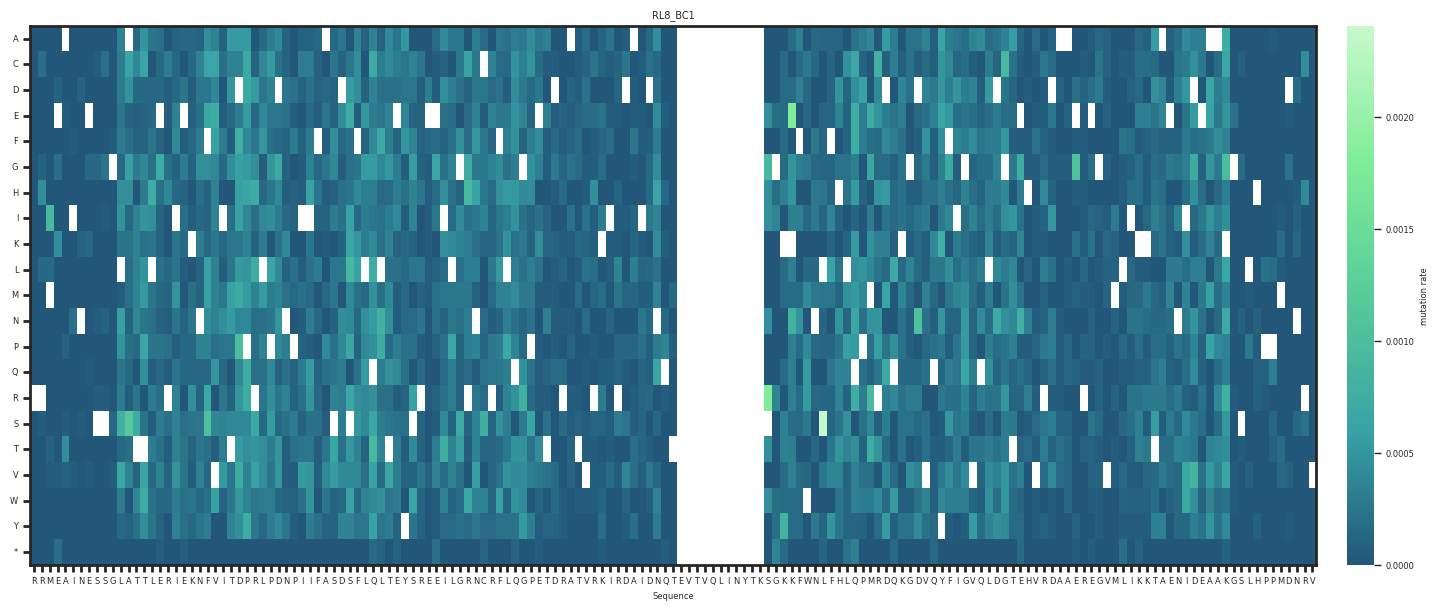

In [ ]:


# Create the custom colormap
# custom_cmap = mcolors.LinearSegmentedColormap.from_list("black_to_blue_to_yellow", colors)



plot_mutation_enrichment(total_relative_enrichment, ref_seq=reference, samplename=f"{variant}_{Bc}", data_type="AA", FigFolder=FigFolder, vmax=None, cmap = custom_cmap, )

In [47]:
### if you want, you can now also filter for the region of interest: 
roi_startidx = LOV2_startidx if data_type == "DNA" else LOV2_startidx//3
roi_endidx = LOV2_endidx if data_type == "DNA" else LOV2_endidx//3

total_relative_enrichment_roi = total_relative_enrichment.iloc[:,roi_startidx:roi_endidx]

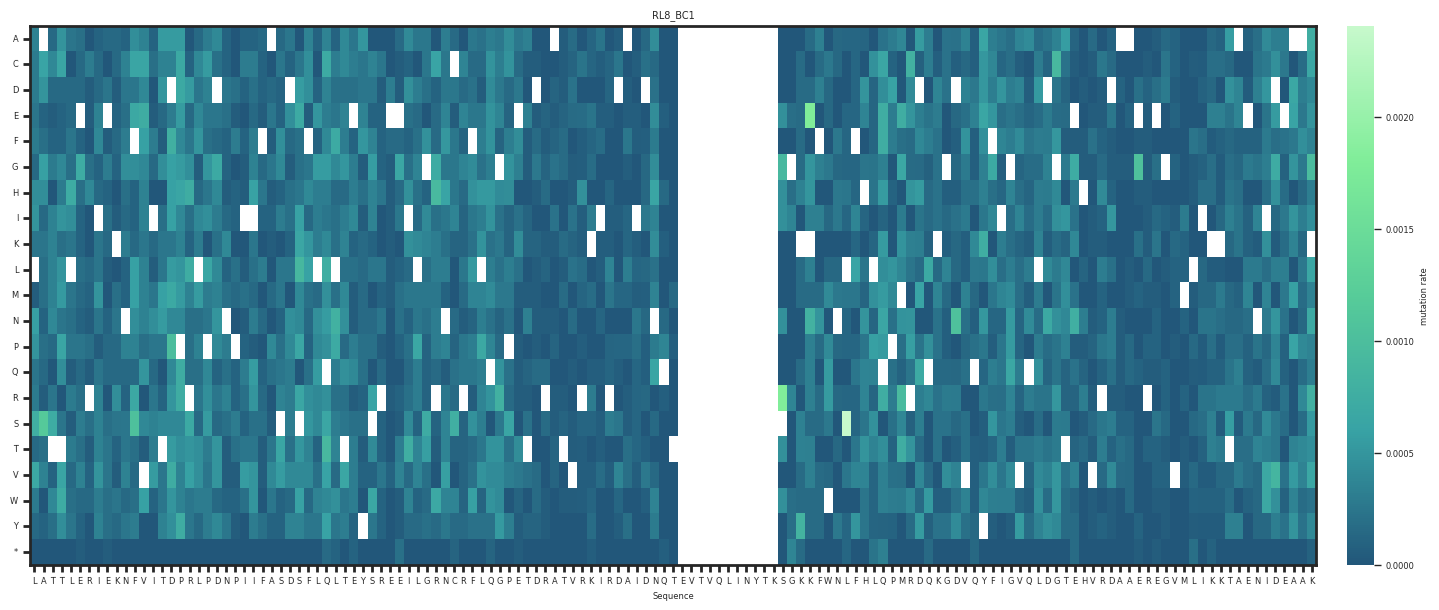

In [48]:
plot_mutation_enrichment(total_relative_enrichment_roi, ref_seq=reference[roi_startidx:roi_endidx], samplename=f"{variant}_{Bc}", data_type="AA", FigFolder=FigFolder, vmax=None, cmap = custom_cmap)

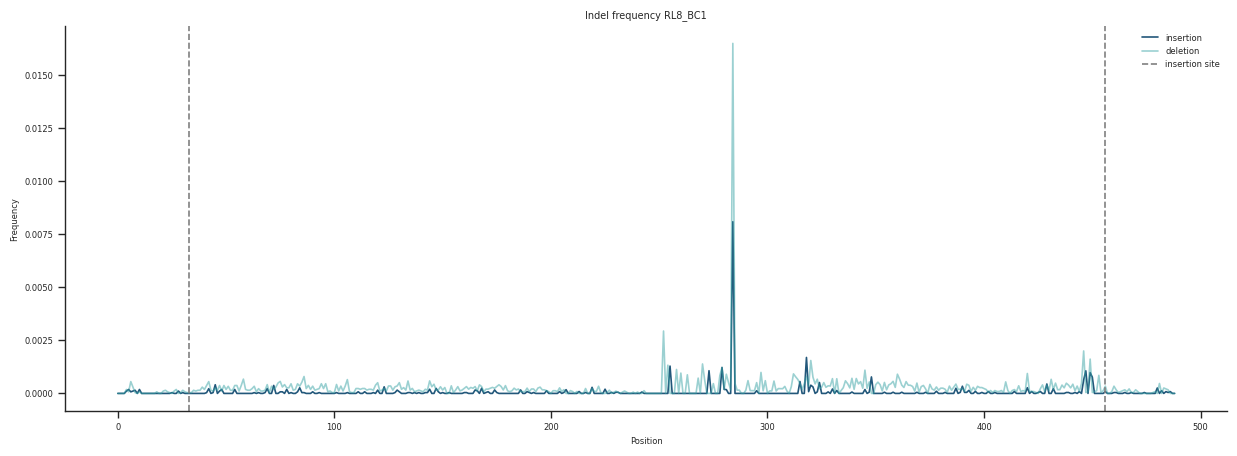

In [13]:
plot_indel_freqs(total_indels_freq,  filename=f"{variant}_{Bc}", FigFolder=FigFolder, roi_start_idx=LOV2_startidx, roi_end_idx=LOV2_endidx, color1="#22577A", color2="#38A3A5")
plt.show()

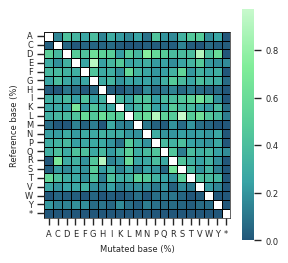

In [49]:
total_relative_enrichment.fillna(0, inplace=True)
x,y = calc_mut_spectrum_from_enrichment(total_relative_enrichment, ref_seq=reference, data_type="AA")
plot_mutation_spectrum(y, data_type="AA", colormap=custom_cmap)

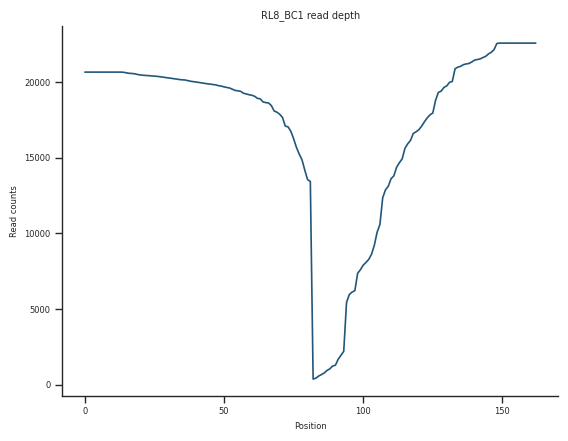

In [17]:
## we can also plot the coverage
coverage_plot(total_variants.sum(), FigFolder=FigFolder, samplename = f"{variant}_{Bc}", color = "#22577A")

### Specific analysis: Comparison of DP6 and RL8

In [4]:
DP6_indels = pd.read_csv("/home/student/anna/DMS_analysis/final_output/DP6/combined/enrichments/DNA/DP6_BC1_S1_combined_roiFalse_DNA_indel_freq.csv", index_col=0)
RL8_indels = pd.read_csv("/home/student/anna/DMS_analysis/final_output/RL8/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_indel_freq.csv", index_col=0)  
RL8_mutations = pd.read_csv("/home/student/anna/DMS_analysis/final_output/RL8/combined/enrichments/AA/RL8_BC1_S1_combined_roiTrue_AA_enrichment_relative.csv", index_col=0)
DP6_mutations = pd.read_csv("/home/student/anna/DMS_analysis/final_output/DP6/combined/enrichments/AA/DP6_BC1_S1_combined_roiTrue_AA_enrichment_relative.csv", index_col=0)

DP6_indels.dropna(axis=1, how="any", inplace=True)
RL8_indels.dropna(axis=1, how="any", inplace=True)

In [9]:
DP6_insertions = DP6_indels.loc["insertion",:]
RL8_insertions = RL8_indels.loc["insertion",:]
DP6_deletions = DP6_indels.loc["deletion",:]
RL8_deletions = RL8_indels.loc["deletion",:]
DP6_muts = DP6_mutations.sum()
RL8_muts = RL8_mutations.sum()
#

# Define colors
color_DP6 = "#22577A"  
color_RL8 = "#57CC99"  
median_color = "black"  

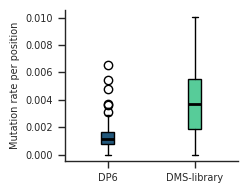

In [12]:
# Mutations
plt.figure(figsize = (wi3, hi/4))
bp = plt.boxplot([DP6_muts, RL8_muts], tick_labels=["DP6", "DMS-library"], 
                       showfliers=True, patch_artist=True)
#plt.title("Mutations")
plt.ylabel("Mutation rate per position")
# Set colors for each dataset in each boxplot

for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
    box.set(facecolor=color)  # Fill the box with the defined color

for median in bp['medians']:
    median.set(color=median_color, linewidth=2)  # Set median color
plt.savefig("/home/student/anna/DMS_analysis/final_output/DP6_vs_RL8_mutationrate_per_pos_boxplot.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig("/home/student/anna/DMS_analysis/final_output/DP6_vs_RL8_mutationrate_per_pos_boxplot.png", bbox_inches = "tight", dpi = 600)

plt.show()

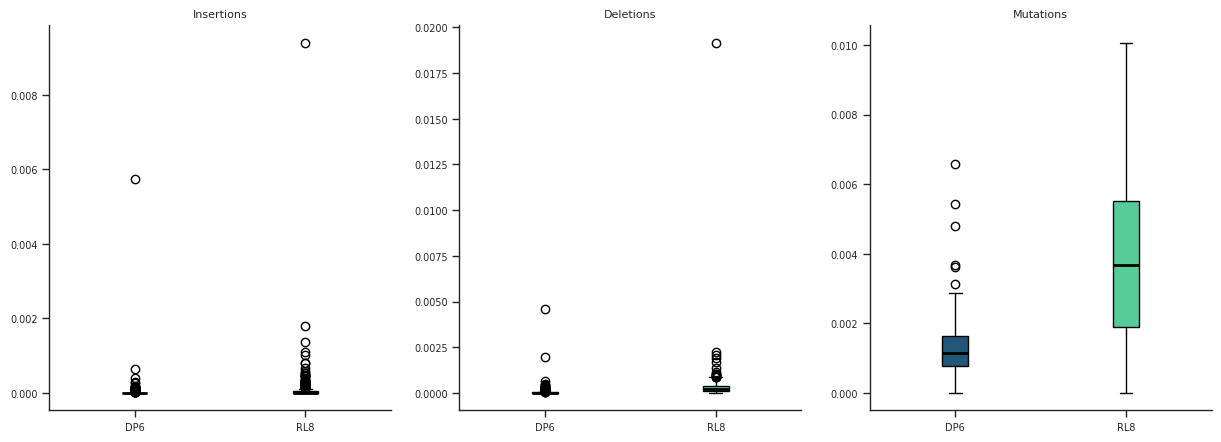

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Insertions
bp1 = axes[0].boxplot([DP6_insertions, RL8_insertions], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[0].set_title("Insertions")

# Deletions
bp2 = axes[1].boxplot([DP6_deletions, RL8_deletions], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[1].set_title("Deletions")

# Mutations
bp3 = axes[2].boxplot([DP6_muts, RL8_muts], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[2].set_title("Mutations")

# Set colors for each dataset in each boxplot
for bp in [bp1, bp2, bp3]:
    for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
        box.set(facecolor=color)  # Fill the box with the defined color

    for median in bp['medians']:
        median.set(color=median_color, linewidth=2)  # Set median color

plt.savefig("/home/student/anna/DMS_analysis/final_output/DP6_vs_RL8_mutationrates_indelrates_boxplot.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig("/home/student/anna/DMS_analysis/final_output/DP6_vs_RL8_mutationrates_indelrates_boxplot.png", bbox_inches = "tight", dpi = 600)
plt.show()




In [14]:
print(np.mean(DP6_muts), "median DP6 mutations per position ")
print(np.mean(RL8_muts), "median RL8 mutations per position ")

0.0013447080673504577 median DP6 mutations per position 
0.0037681644787783608 median RL8 mutations per position 


In [15]:
all_DP6_mutations = DP6_mutations.iloc[:-1,:].values.flatten()
all_RL8_mutations = RL8_mutations.iloc[:-1,:].values.flatten()

all_DP6_mutations = all_DP6_mutations[~np.isnan(all_DP6_mutations)]
all_RL8_mutations = all_RL8_mutations[~np.isnan(all_RL8_mutations)]

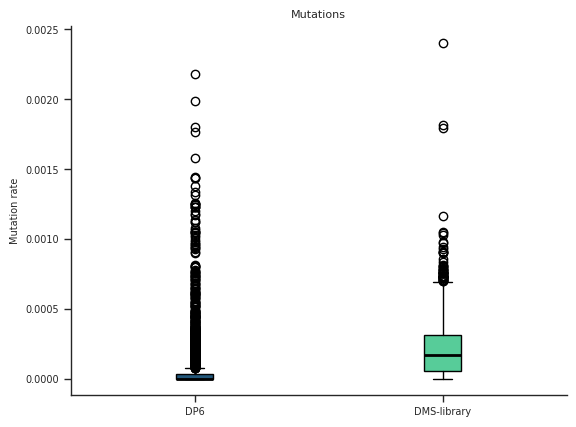

In [17]:
# Mutations (all possible, not per position)
bp = plt.boxplot([all_DP6_mutations, all_RL8_mutations], tick_labels=["DP6", "DMS-library"], 
                       showfliers=True, patch_artist=True)
plt.title("Mutations")
plt.ylabel("Mutation rate")
# Set colors for each dataset in each boxplot

for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
    box.set(facecolor=color)  # Fill the box with the defined color

for median in bp['medians']:
    median.set(color=median_color, linewidth=2)  # Set median color

plt.show()

In [80]:
print(np.median(DP6_muts), "median DP6 mutations per position ")
print(np.median(RL8_muts), "median RL8 mutations per position ")
print(np.median(all_DP6_mutations), "median DP6 mutations per possible change")
print(np.median(all_RL8_mutations), "median RL8 mutations per possible change")

0.0011526479750777452 median DP6 mutations per position 
0.0036900369003680005 median RL8 mutations per position 
0.0 median DP6 mutations per possible change
0.0001690180521563 median RL8 mutations per possible change


## Specific characterization of the DMS-library (RL8) -> comparison of mutation enrichmetn to the input library

In [3]:
RL8_mutations = pd.read_csv("/home/student/anna/DMS_analysis/final_output/RL8/combined/enrichments/AA/RL8_BC1_S1_combined_roiFalse_AA_enrichment_relative.csv", index_col=0)
RL8_DNA_mutations = pd.read_csv("/home/student/anna/DMS_analysis/final_output/RL8/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_enrichment_relative.csv", index_col=0)
RL8_encoded_muts = pd.read_csv("/home/student/anna/DMS_analysis/final_output/P0111_RetronLib/BC3_R1/blastpipeline/enrichments/BC3_RL_encoded_mutations.csv", index_col=0).T


RL8_observed_ref = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
## see /home/student/anna/DMS_analysis/data/fastq/P02_RL8_LOV2/references/RL8_BC1_S1_Nt_filt_ref.fasta

RL8_encoded_ref = "CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC"
cut_left = RL8_encoded_ref.index("CGCCGCATGGAAGCGATTAA")
cut_right = RL8_encoded_ref.index("TGGATAACCGCGTG") + len("TGGATAACCGCGTG")

In [4]:
empty_cols = RL8_DNA_mutations.columns[RL8_DNA_mutations.isna().all()] #empty due to low coverage

RL8_DNA_muts_prop = RL8_DNA_mutations.sum()
## mask pos with max (silent mutation that likely is contamination)
mask_max = RL8_DNA_muts_prop.idxmax()
RL8_DNA_muts_prop[mask_max] = np.nan

# normalize
RL8_DNA_muts_prop = RL8_DNA_muts_prop/RL8_DNA_muts_prop.sum()

# sum total mutation rate per position 
RL8_DNA_mutations_sum = RL8_DNA_mutations.sum()  

# mask again since the mask is lost when doing the sum
RL8_DNA_mutations_sum[mask_max] = np.nan
RL8_DNA_mutations_sum[empty_cols] = np.nan
RL8_DNA_muts_prop[mask_max] = np.nan
RL8_DNA_muts_prop[empty_cols] = np.nan


In [5]:
## cut encoded region to same frame as observed region
RL8_encoded_muts = RL8_encoded_muts.iloc[:,cut_left:cut_right]

## mask the same positions as in the observed region (due to low coverage )
empty_cols = RL8_DNA_mutations.columns[RL8_DNA_mutations.isna().all()]
empty_cols = [int(empty_col) for empty_col in empty_cols]
RL8_encoded_muts_prop = RL8_encoded_muts.iloc[0,:].values
RL8_encoded_muts_prop = pd.DataFrame([RL8_encoded_muts_prop[i] if i not in empty_cols+ [int(mask_max)] else np.nan for i in range(len(RL8_encoded_muts_prop))])


## normalize so that the sum is 1
RL8_encoded_muts_prop = (RL8_encoded_muts_prop/RL8_encoded_muts_prop.sum()).values.flatten()

In [6]:
light_gray = "black"  # Light gray
dark_gray = "#D3D3D3"   # Dark gray

gray_cmap = mcolors.LinearSegmentedColormap.from_list("custom_gray", [light_gray, dark_gray])


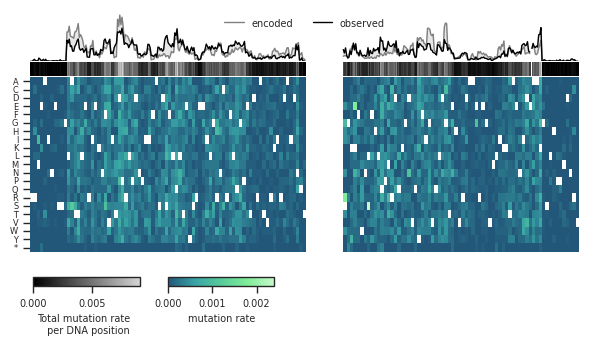

In [7]:
fig, axes = plt.subplots(3,1, figsize=(wi, hi/2.5), height_ratios=[0.3, 0.08, 1])
## put plots closer together
plt.subplots_adjust(hspace=0.01)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

axes[0].plot(RL8_encoded_muts_prop, label = "encoded", linewidth = 1, color = "grey")#, color = "#22577A")
axes[0].plot(RL8_DNA_muts_prop, label = "observed", linewidth = 1, color = "black")#, color ="#38A3A5")
axes[0].set_xlim(0, len(RL8_encoded_muts.columns))
axes[0].set_ylim(0,0.012)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend(frameon = False, ncol=2)
axes[0].fill_between(range(len(RL8_encoded_muts_prop)), RL8_encoded_muts_prop, RL8_DNA_muts_prop, color= "lightgrey", alpha=0.5)

sns.heatmap(pd.DataFrame(RL8_DNA_mutations_sum).T, cmap= gray_cmap, cbar = False, ax = axes[1], xticklabels=False, yticklabels=False)


colors = [
    #"#2C3E5E",  
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
]

# Create the colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)
sns.heatmap(RL8_mutations, cmap= custom_cmap, cbar = False, ax = axes[2],yticklabels=True,xticklabels=False)
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=1, fontsize = 6)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=1)

cbar_ax = fig.add_axes([0.13, -0.0, 0.15, 0.03])
cbar = fig.colorbar(axes[1].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("Total mutation rate  \n per DNA position")

cbar_ax = fig.add_axes([0.32, -0.0, 0.15, 0.03])
cbar = fig.colorbar(axes[2].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate")


plt.savefig("/home/student/anna/DMS_analysis/final_output/RL8/RL8_encoded_vs_observed.pdf", bbox_inches='tight')
plt.savefig("/home/student/anna/DMS_analysis/final_output/RL8/RL8_encoded_vs_observed.png", bbox_inches='tight')

plt.show()

In [46]:
## drop nan values
RL8_DNA_muts_prop = RL8_DNA_muts_prop.dropna()
RL8_encoded_muts_prop = pd.DataFrame(RL8_encoded_muts_prop).dropna()

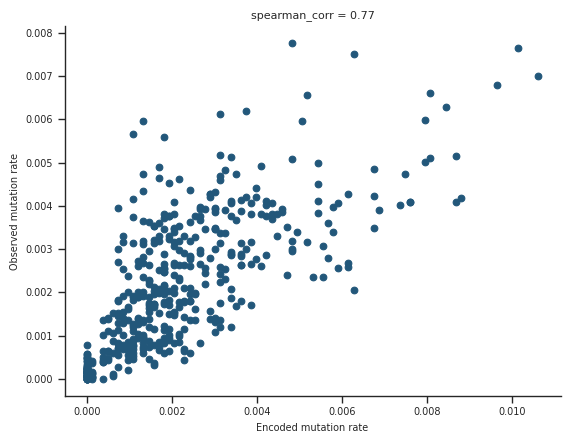

In [48]:
plt.scatter(RL8_encoded_muts_prop, RL8_DNA_muts_prop, color = "#22577A")
plt.title(f"spearman_corr = {round(scipy.stats.spearmanr(RL8_encoded_muts_prop, RL8_DNA_muts_prop)[0],2)}")
plt.xlabel("Encoded mutation rate")
plt.ylabel("Observed mutation rate")


plt.savefig("/home/student/anna/DMS_analysis/final_output/RL8/RL8_encoded_vs_observed_correlation.pdf", bbox_inches='tight')
plt.savefig("/home/student/anna/DMS_analysis/final_output/RL8/RL8_encoded_vs_observed_correlation.png", bbox_inches='tight')

### Is RamPhage biased towards codons with single/double/triple base changes? 

In [55]:
ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}


In [49]:
variant = "RL8"
### get enrichment 
Folder = f"/home/student/anna/DMS_analysis/final_output/{variant}/combined/" 
enrichment_counts = pd.read_csv(f"{Folder}/enrichments/Codons/{variant}_BC1_S1_combined_roiTrue_Codons_enrichment_counts.csv", index_col = 0)
FigFolder = Folder+ "/plots/Codons/"


In [50]:
amplicon_AraCLOV2 = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
start_LOV2  = "ttagccacaa".upper() ## LOV2 start # set region of interest, that has to be included in the reads to be considered for the analysis, e.g. LOV2 start site
end_LOV2 = "cggccaaa".upper() ## LOV2 end

LOV2_gene = amplicon_AraCLOV2[amplicon_AraCLOV2.index(start_LOV2):amplicon_AraCLOV2.index(end_LOV2)+len(end_LOV2)]

In [51]:
enrichment_counts_sum = enrichment_counts.sum()
## mask pos with max 
mask_max = np.where(enrichment_counts_sum == enrichment_counts_sum.max())[0][0]
enrichment_counts.iloc[:,mask_max] = 0


In [52]:
## calculate number of single/double/triple Nt changes codon-wise
ref_codons = [LOV2_gene[i:i+3] for i in range(0, len(LOV2_gene), 3)]

Nt_changes = {1:0, 2:0, 3:0} # single,double,triple Nt mutations within codons


for pos, ref_codon in enumerate(ref_codons): # iterate through ref_codons
    mut_Codons = enrichment_counts.iloc[:,pos] # get the respective column of the enrichment df
    for mut_codon in mut_Codons.index:
        if mut_codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)]) # count number of nt changes within the codon
            Nt_changes[n_changes] += mut_Codons[mut_codon] # add the count of the mutated codon to the respective category

relative_Nt_changes_observed = {key: val/sum(Nt_changes.values()) for key,val in Nt_changes.items()}
        

In [53]:
relative_Nt_changes_observed
Nt_changes

{1: np.float64(2909.0), 2: np.float64(3727.0), 3: np.float64(3402.0)}

In [56]:
## calculate expected number of single/double/triple Nt changes codon-wise
expected_Nt_changes = {1:0, 2:0, 3:0}

for ref_codon in ref_codons: 
    for mut_Codon in ecoli_pref.values(): 
        if mut_Codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_Codon[i] for i in range(3)])
            expected_Nt_changes[n_changes] += 1

relative_expected_Nt_changes = {key: val/sum(expected_Nt_changes.values()) for key, val in expected_Nt_changes.items()}

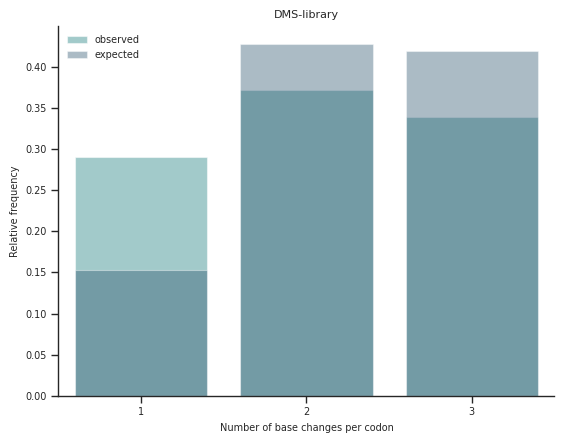

In [57]:
sns.barplot(relative_Nt_changes_observed, alpha = 0.5, label = "observed", color = "#38A3A5")
sns.barplot(relative_expected_Nt_changes, alpha = 0.4, label = "expected", color = "#22577A")
plt.legend(frameon = False)
plt.xlabel("Number of base changes per codon")
plt.ylabel("Relative frequency")
plt.title("DMS-library")
plt.savefig(f"{FigFolder}/{variant}_base_changes_per_codon_exp_vs_obs.pdf")
plt.show()